# MultiEmo - english translated Polemo2.0

In [1]:
from pathlib import Path

import pandas as pd
import seaborn as sns

from src.settings import DATA_DIR

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
MULTIEMO_DIR = DATA_DIR.joinpath('multiemo_en')


def get_frame(path: Path, split: str, label_prefix: str = '__label__meta_') -> pd.DataFrame:
    with path.open() as f:
        lines = f.readlines()

    texts = []
    labels = []

    for line in lines:
        text, label = line.split(label_prefix)
        labels.append(label.rstrip('\n'))
        texts.append(text.strip())

    df = pd.DataFrame(list(zip(texts, labels)), columns=['text', 'label'])
    df['split'] = split
    return df


def get_stats(mode: str, domain: str):
    train_path = MULTIEMO_DIR.joinpath(f'{domain}.{mode}.train.txt')
    val_path = MULTIEMO_DIR.joinpath(f'{domain}.{mode}.dev.txt')
    test_path = MULTIEMO_DIR.joinpath(f'{domain}.{mode}.test.txt')

    df_train = get_frame(train_path, split='train')
    df_val = get_frame(val_path, split='val')
    df_test = get_frame(test_path, split='test')

    print(f'Len train: {len(df_train)}')
    print(f'Len val: {len(df_val)}')
    print(f'Len test: {len(df_test)}')

    df_all = pd.concat([df_train, df_val, df_test], ignore_index=True)

    print(f'Sentiment labels: {df_all.label.unique()}')

    g = sns.FacetGrid(df_all, col="split")
    g.map(sns.countplot, 'label', order=[
        'minus_m',
        'zero',
        'amb',
        'plus_m',
    ])

    # Annotate a value into each bar in each plot
    for ax in g.axes.ravel():
        for p in ax.patches:
            ax.annotate(
                format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center',
                va='center',
                xytext=(0, 10),
                textcoords='offset points',
            )
    return g, df_all

### Class distribution

Len train: 6572
Len val: 823
Len test: 820
Sentiment labels: ['minus_m' 'plus_m' 'zero' 'amb']


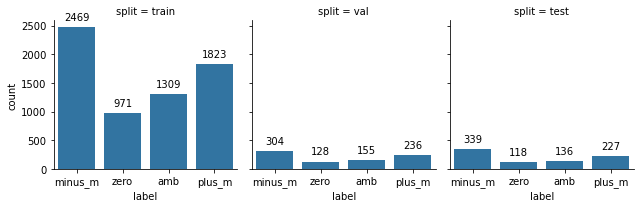

In [3]:
mode = 'text'
domain = 'all'

g, df_all = get_stats(mode=mode, domain=domain)

### text length

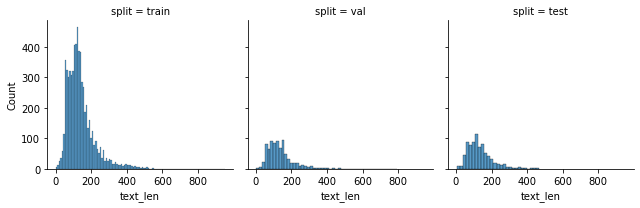

In [4]:
df_all['text_len'] = df_all.text.apply(lambda x: len(x.split(' ')))

g = sns.FacetGrid(df_all, col="split")
g.map(sns.histplot, 'text_len')

### Tokenized text lengths

In [7]:
from transformers import AutoTokenizer

HUGGINGFACE_MODEL_NAME = 'bert-base-cased'
tokenizer = AutoTokenizer.from_pretrained(HUGGINGFACE_MODEL_NAME, do_lower_case=True)

texts = df_all['text'].values.tolist()

text_tokenized = tokenizer(
    texts,
    add_special_tokens=True,
    return_token_type_ids=False,
    return_attention_mask=False,
    truncation=False,
    padding=False,
    return_length=True
)
text_tokens = text_tokenized['input_ids']
lengths = text_tokenized['length']

df_all['tok_len'] = lengths
df_all.head()

Token indices sequence length is longer than the specified maximum sequence length for this model (524 > 512). Running this sequence through the model will result in indexing errors


,text,label,split,text_len,tok_len
0,"At the very entrance, the hotel stinks. There ...",minus_m,train,65,81
1,With my children (10 years old and 2 years old...,plus_m,train,114,148
2,I wanted to get 'em a set for basic work somet...,minus_m,train,136,162
3,Dear Mom. I have the same opinion about this b...,minus_m,train,139,177
4,"Actually, I didn't find out anything to em, du...",minus_m,train,106,144


In [8]:
df_all.describe()

,text_len,tok_len
count,8215.000000,8215.000000
mean,140.179063,176.633232
std,79.587290,98.419258
min,1.000000,2.000000
25%,88.000000,111.000000
50%,125.000000,158.000000
75%,168.000000,212.500000
max,951.000000,1202.000000


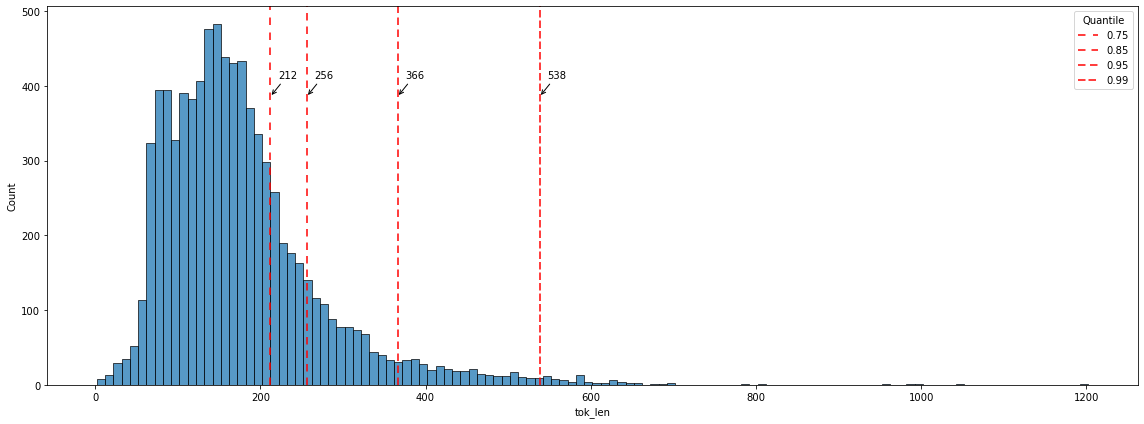

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16, 6))

sns.histplot(x='tok_len', data=df_all, ax=ax)
max_val = max([p.get_height() for p in ax.patches])
for q, ls in zip([0.75, 0.85, 0.95, 0.99], [(0, (5, 5)), (0, (5, 4)), (0, (5, 3)), (0, (5, 2))]):
    qv = int(df_all['tok_len'].quantile(q))
    ax.axvline(qv, color='red', ls=ls, lw=1.5, label=q)
    ax.annotate(
        qv,
        xy=(qv, max_val * 0.8),
        xytext=(qv + 9, max_val * 0.85),
        arrowprops=dict(arrowstyle="->", color='black'),
    )

ax.legend(title='Quantile')

fig.tight_layout()